# packages

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.metrics import davies_bouldin_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.decomposition import PCA
import scikitplot as skplt
from yellowbrick.cluster import KElbowVisualizer
from scipy.stats import randint, uniform
from tune_sklearn import TuneSearchCV
from ray import tune
import os
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [2]:
os.environ['RAY_IGNORE_UNHANDLED_ERRORS'] = '1'
#ray.init()
import ray

# dataset

In [3]:
lines = open('../module_04-working_with_the_notebook/data/spambase.names').readlines()[33:]
colnames = [x.split(':')[0] for x in lines]
colnames.append('spam_class')

In [4]:
df = pd.read_csv('../module_04-working_with_the_notebook/data/spambase.data', header = None)
df.columns = colnames

In [5]:
df.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam_class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

In [7]:
df.nunique()

word_freq_make                 142
word_freq_address              171
word_freq_all                  214
word_freq_3d                    43
word_freq_our                  255
word_freq_over                 141
word_freq_remove               173
word_freq_internet             170
word_freq_order                144
word_freq_mail                 245
word_freq_receive              113
word_freq_will                 316
word_freq_people               158
word_freq_report               133
word_freq_addresses            118
word_freq_free                 253
word_freq_business             197
word_freq_email                229
word_freq_you                  575
word_freq_credit               148
word_freq_your                 401
word_freq_font                  99
word_freq_000                  164
word_freq_money                143
word_freq_hp                   395
word_freq_hpl                  281
word_freq_george               240
word_freq_650                  200
word_freq_lab       

In [8]:
df.describe(include = 'all')

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam_class
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


# data prep for clustering

In [9]:
x = df.iloc[:, :-1]
y = df['spam_class']
scaler = StandardScaler()
rscaler = RobustScaler(quantile_range = (1,99))
x_scaled = scaler.fit_transform(x)
x_robust = rscaler.fit_transform(x)
max_clusters = 20

In [10]:
kmeans = KMeans(n_init = 10)

# clustering on standard scaled data

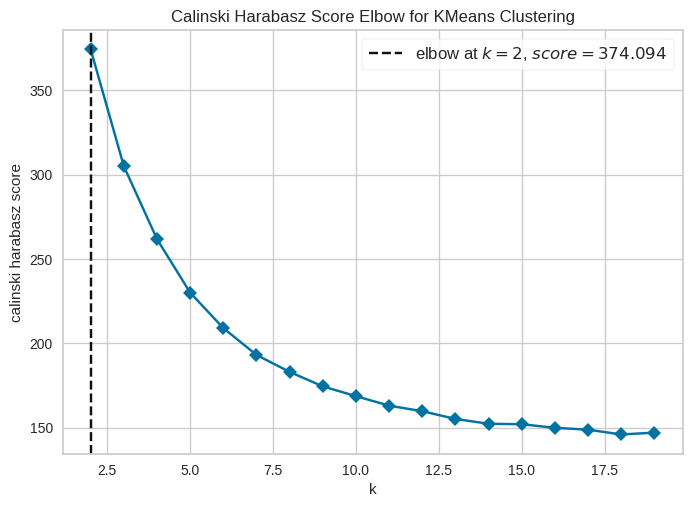

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [66]:
model = KMeans(n_init = 100)
visualizer = KElbowVisualizer(
    model, k=(2,max_clusters), metric='calinski_harabasz', timings=False
)

visualizer.fit(x_scaled)        # Fit the data to the visualizer
visualizer.show() 

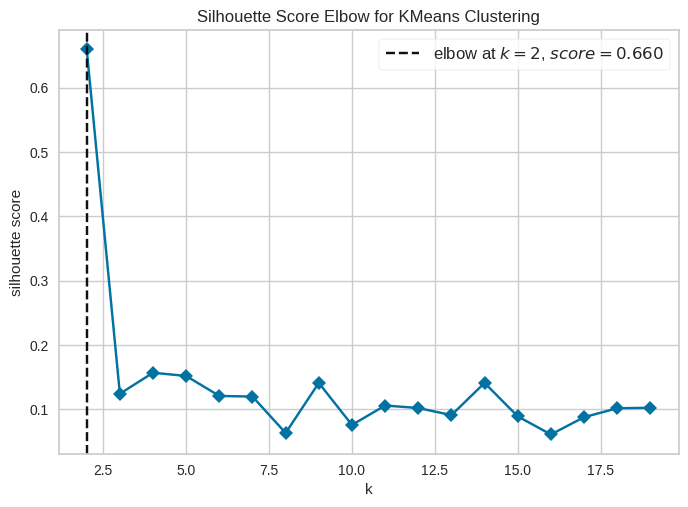

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [67]:
model = KMeans(n_init = 10)
visualizer = KElbowVisualizer(
    model, k=(2,max_clusters), metric='silhouette', timings=False
)

visualizer.fit(x_scaled)        # Fit the data to the visualizer
visualizer.show() 

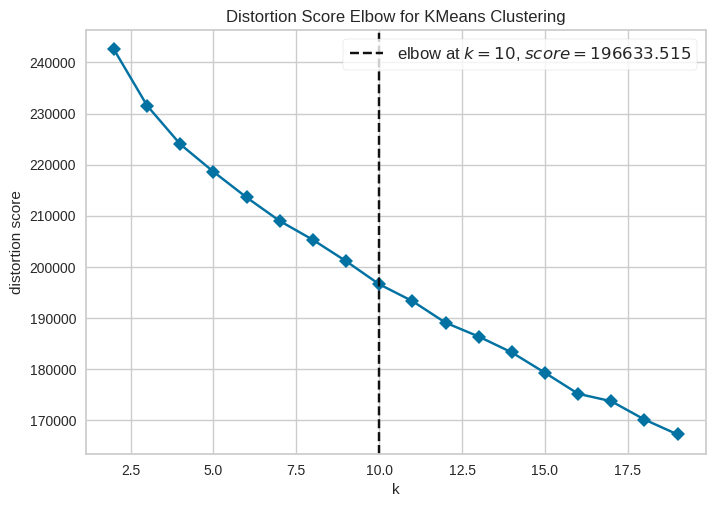

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [68]:
model = KMeans(n_init = 100)
visualizer = KElbowVisualizer(
    model, k=(2,max_clusters), metric='distortion', timings=False
)

visualizer.fit(x_scaled)        # Fit the data to the visualizer
visualizer.show() 

In [69]:
for i in range(2, max_clusters + 1):
    kmeans = KMeans(n_init = 10, n_clusters = i)
    clusters = kmeans.fit_predict(x_scaled)
    db = davies_bouldin_score(x_robust, clusters) # lower values better clustering
    print(i, db)

2 1.021922435322595
3 3.8242572344385457
4 3.5280220520076884
5 3.0825845478218903
6 3.374980907538209
7 3.0525358097432758
8 2.853322314886118
9 3.0065197521273386
10 2.6889891365986145
11 3.3700489051334355
12 3.9201811883229407
13 2.762120801514916
14 2.237401767901576
15 2.5877369554182263
16 2.4654633198093405
17 2.6345580602625462
18 2.922906445748099
19 2.2180058717755817
20 2.2763512600556117


# clustering on robust scaled data

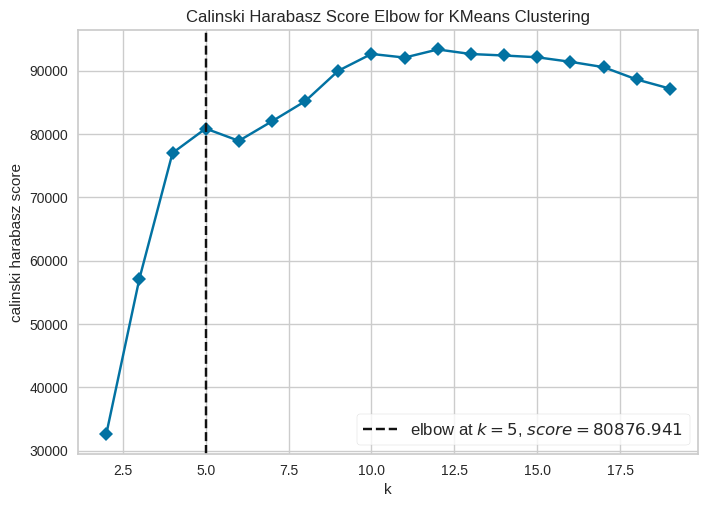

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [70]:
model = KMeans(n_init = 100)
visualizer = KElbowVisualizer(
    model, k=(2,max_clusters), metric='calinski_harabasz', timings=False
)

visualizer.fit(x_robust)        # Fit the data to the visualizer
visualizer.show() 

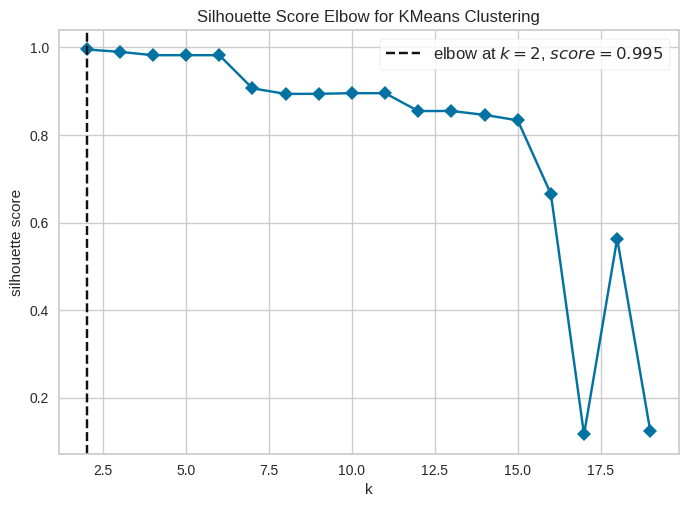

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [71]:
model = KMeans(n_init = 10)
visualizer = KElbowVisualizer(
    model, k=(2,max_clusters), metric='silhouette', timings=False
)

visualizer.fit(x_robust)        # Fit the data to the visualizer
visualizer.show() 

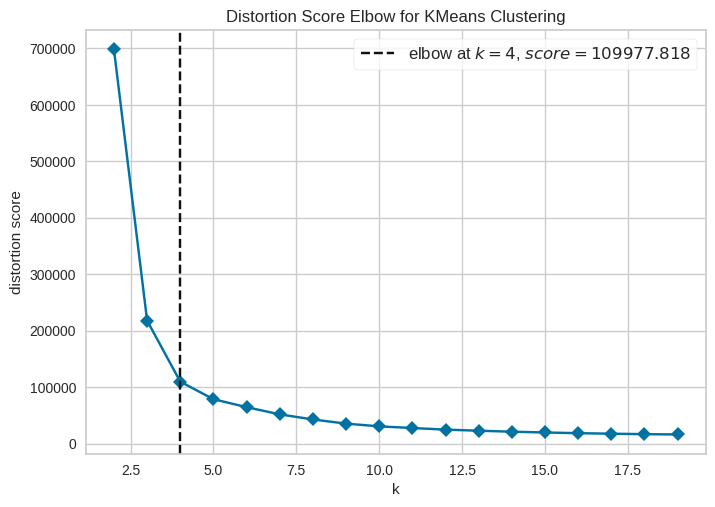

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [72]:
model = KMeans(n_init = 100)
visualizer = KElbowVisualizer(
    model, k=(2,max_clusters), metric='distortion', timings=False
)

visualizer.fit(x_robust)        # Fit the data to the visualizer
visualizer.show() 

In [73]:
for i in range(2, max_clusters + 1):
    kmeans = KMeans(n_init = 10, n_clusters = i)
    clusters = kmeans.fit_predict(x_robust)
    db = davies_bouldin_score(x_robust, clusters) # lower values better clustering
    print(i, db)

2 0.2436533043521325
3 0.35875755234913864
4 0.3117376522892262
5 0.270394503950568
6 0.19956567068548212
7 0.2791605078317634
8 0.32610590736046174
9 0.33291191579726154
10 0.3496332276605726
11 0.2614059561800546
12 0.22625056918689915
13 0.29514277258287935
14 0.22864196727096742
15 0.2671983614471886
16 0.28668972199033
17 0.6787898230284535
18 0.3221619066503239
19 0.6652274974801201
20 0.6140661809500574


# training xgboost model to predict spam_class

In [11]:
x.rename(columns = {'char_freq_[':'char_freq_left_square_bracket'}, inplace = True)

## single model

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [13]:
xgbc = XGBClassifier()
xgbc.fit(x_train, y_train)
xgbc.score(x_test, y_test)

0.9507603186097031

### eval

In [36]:
y_test_pred = xgbc.predict(x_test)
y_test_pred_probas = xgbc.predict_proba(x_test)
cm = confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       822
           1       0.95      0.93      0.94       559

    accuracy                           0.95      1381
   macro avg       0.95      0.95      0.95      1381
weighted avg       0.95      0.95      0.95      1381



<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

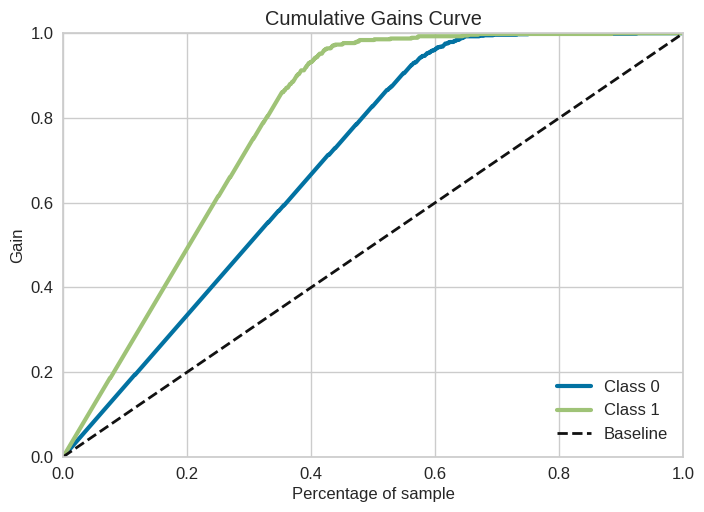

In [37]:
skplt.metrics.plot_cumulative_gain(y_test, y_test_pred_probas)

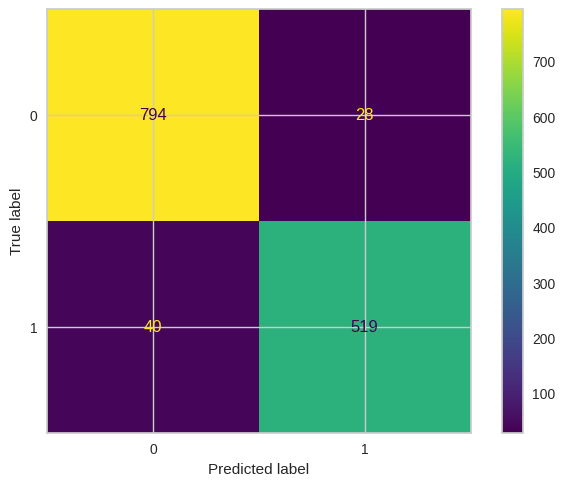

In [32]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgbc.classes_)
disp.plot()

## cross validation

In [19]:
scoring = ['accuracy', 'precision', 'recall', 'f1']
cv_results = cross_validate(xgbc, x_train, y_train, cv=3, return_train_score = True,
                           scoring = scoring)

In [20]:
cv_results

{'fit_time': array([0.85714388, 0.49422503, 0.52751875]),
 'score_time': array([0.01686835, 0.01908112, 0.01472378]),
 'test_accuracy': array([0.95065177, 0.95060578, 0.95899348]),
 'train_accuracy': array([0.99906803, 1.        , 0.99953423]),
 'test_precision': array([0.94188862, 0.95061728, 0.9538835 ]),
 'train_precision': array([1., 1., 1.]),
 'test_recall': array([0.93062201, 0.92105263, 0.94019139]),
 'train_recall': array([0.99760766, 1.        , 0.99880383]),
 'test_f1': array([0.93622142, 0.93560146, 0.94698795]),
 'train_f1': array([0.9988024 , 1.        , 0.99940156])}

In [30]:
s_feat = pd.Series(xgbc.feature_importances_, index = x.columns).sort_values(ascending = False)
s_feat[:10]

word_freq_remove     0.152953
char_freq_$          0.115708
char_freq_!          0.110676
word_freq_hp         0.058219
word_freq_money      0.049513
word_freq_george     0.043283
word_freq_edu        0.031721
word_freq_650        0.029474
word_freq_meeting    0.024762
word_freq_free       0.024463
dtype: float32

# pipeline

## pipeline 1

In [53]:
estimators = [('f_selection', SelectKBest(f_classif, k=20)),
         ('normalization', RobustScaler()),
         ('model', XGBClassifier())]
pipe1 = Pipeline(estimators)

In [54]:
pipe1.fit(x_train, y_train)

Pipeline(steps=[('f_selection', SelectKBest(k=20)),
                ('normalization', RobustScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [55]:
pipe1.score(x_test, y_test)

0.9304851556842868

## pipeline 2

In [71]:
estimators2 = [('normalization', StandardScaler()),
              ('dim_reduction', PCA(n_components = 0.9)),
         ('model', XGBClassifier())]
pipe2 = Pipeline(estimators2)

In [72]:
pipe2.fit(x_train, y_train)

Pipeline(steps=[('normalization', StandardScaler()),
                ('dim_reduction', PCA(n_components=0.9)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [73]:
pipe2.score(x_test, y_test)

0.9312092686459088

### accessing steps of the pipeline

In [74]:
pipe2.steps

[('normalization', StandardScaler()),
 ('dim_reduction', PCA(n_components=0.9)),
 ('model',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                predictor=None, random_state=None, ...))]

In [75]:
pipe2.steps[1]

('dim_reduction', PCA(n_components=0.9))

In [76]:
pipes_pca = pipe2.steps[1][1]
pipes_pca.explained_variance_, len(pipes_pca.explained_variance_)

(array([6.3517596 , 3.30215164, 2.08022638, 1.61876833, 1.54318722,
        1.4530206 , 1.40930122, 1.38980434, 1.27238481, 1.25475409,
        1.22183697, 1.14252778, 1.13767565, 1.12744548, 1.08915204,
        1.0668612 , 1.06284095, 1.02552981, 1.01784802, 1.0038006 ,
        0.9881778 , 0.98299326, 0.96232484, 0.94602145, 0.92942268,
        0.92642639, 0.9175699 , 0.89028295, 0.85742543, 0.84278727,
        0.83277166, 0.82266145, 0.80455665, 0.78621597, 0.77256043,
        0.74417999, 0.72809204, 0.72184733, 0.70102163, 0.69228696,
        0.67610326, 0.66048692, 0.62429185]),
 43)

### executing part of the pipeline

In [82]:
pd.DataFrame(pipe2[:2].transform(x_train))

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.178119,-2.261315,1.387835,-4.160928,-1.225356,1.345457,0.292801,-0.239486,-1.682307,-0.665878,...,-1.660434,-0.781275,-3.181375,0.068687,-0.415364,-2.025307,0.538151,-0.417441,0.364079,0.555846
1,-0.775437,0.243901,-0.259017,0.211693,-0.184304,-0.237040,0.242502,0.259025,-0.089776,0.636201,...,-0.516762,1.039686,-0.074109,0.288743,0.238862,0.073147,0.302368,-0.552002,-0.446526,0.095577
2,-0.333879,-1.429266,-0.202136,0.639345,0.127369,-0.408080,-0.081066,-0.349463,0.255788,0.228339,...,-0.093453,0.061913,-0.227266,0.495795,-0.386754,0.559841,0.052665,0.251314,0.126259,-0.572811
3,-0.303121,-1.529996,-0.151045,0.760030,-0.255956,-0.481573,-0.071119,-0.496727,0.226614,0.028985,...,-0.009864,0.416201,-0.373123,0.151721,-0.101146,0.534773,0.023248,0.046380,0.020804,-0.710474
4,0.474400,-0.408871,-0.296591,-0.574320,-0.070587,0.346774,0.194873,-0.106099,0.976477,-0.259792,...,0.603878,-0.410418,-0.101861,0.379269,1.158479,0.173754,0.632620,-0.364840,0.240348,0.733778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,-1.128353,1.451804,-0.864636,-0.193269,0.152209,-0.068458,-0.458809,0.357171,0.253115,0.346066,...,-0.015076,-0.270271,-0.273377,0.290835,0.718299,-0.310065,-0.775601,0.039098,0.390342,0.081493
3216,0.341323,-1.260127,-0.064913,0.724210,0.031224,-0.563607,-0.212060,-0.660587,0.089903,-0.201957,...,0.351124,0.066166,-0.410365,0.467845,0.289454,0.171617,0.059276,-0.206320,0.313068,-0.325085
3217,-1.444083,3.352279,2.255983,0.759612,-0.081677,-0.300111,-0.188375,0.609152,0.022910,3.349595,...,-0.020940,0.238126,-0.276990,-0.234995,0.340593,0.088066,-0.051230,0.181950,1.098775,1.296559
3218,2.833587,-0.869413,0.261453,-0.585286,-0.206770,0.053334,0.110675,-0.383128,-0.431038,0.171280,...,-0.652135,-0.035589,-0.579647,0.076487,-0.208811,-0.212255,0.198441,-0.004660,-0.233243,-0.184456


### cross validation

In [83]:
scoring = ['accuracy', 'precision', 'recall', 'f1']
cv_results_pipe2 = cross_validate(pipe2, x_train, y_train, cv=3, return_train_score = True,
                           scoring = scoring)

In [84]:
cv_results_pipe2

{'fit_time': array([1.33048058, 1.38473439, 0.88287377]),
 'score_time': array([0.02644396, 0.04059935, 0.03142262]),
 'test_accuracy': array([0.9264432 , 0.93103448, 0.93476235]),
 'train_accuracy': array([1., 1., 1.]),
 'test_precision': array([0.91240876, 0.9278607 , 0.91428571]),
 'train_precision': array([1., 1., 1.]),
 'test_recall': array([0.89712919, 0.8923445 , 0.91866029]),
 'train_recall': array([1., 1., 1.]),
 'test_f1': array([0.90470446, 0.9097561 , 0.91646778]),
 'train_f1': array([1., 1., 1.])}

# hyperparameter tuning

## gridsearchCV

### on single model

In [14]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [17]:
grid_search = GridSearchCV(
    estimator=xgbc,
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = 4,
    cv = 3,
    verbose=4,
    return_train_score = True
)

In [18]:
%%time
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=4,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)},
             scoring='accuracy', verbose=True)

In [19]:
grid_search.cv_results_

{'mean_fit_time': array([ 0.54603775,  1.05180359,  1.30983186,  2.28075266,  1.35639755,
         1.52087553,  1.99903758,  3.03084143,  1.47819789,  2.45275601,
         2.2866931 ,  3.25380341,  1.92235104,  3.44229047,  4.19833859,
         5.35939598,  2.63539513,  4.87016582,  5.68172757,  5.8510282 ,
         2.4235057 ,  2.73764459,  4.24105565,  7.35010767,  3.24223884,
         4.23577189,  6.49239429,  8.05556305,  2.81738631,  5.10875177,
         7.1437513 ,  7.49667764,  0.67766913,  0.94105903,  2.30827316,
         3.46828492,  1.50412997,  2.49800356,  2.46651332,  3.16542665,
         1.27869137,  1.74159169,  2.75885089,  3.58501951,  1.55340958,
         2.86693501,  3.80536985,  5.09917808,  2.06409677,  3.10524448,
         5.13911899,  6.42612863,  2.62578646,  4.62114414,  5.40952039,
         8.29795758,  3.24967074,  6.64046566,  8.08224344,  9.96821276,
         3.57602151,  7.60578911,  9.56444335,  8.49942406,  0.65908066,
         0.89735715,  1.82086547, 

In [20]:
grid_search.best_score_

0.9559025409535908

In [21]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 180}

In [22]:
grid_search.best_index_

19

In [24]:
best_estimator =grid_search.best_estimator_

In [25]:
best_estimator.score(x_test, y_test)

0.9493120926864591

### on a pipeline

In [33]:
estimators = [('normalization', StandardScaler()),
         ('model', XGBClassifier())]
pipe = Pipeline(estimators)
param_grid = {'normalization':[StandardScaler(), RobustScaler(), Normalizer(), None],
                  'model__max_depth': range (2, 10, 1),
                    'model__n_estimators': range(60, 220, 40),
                    'model__learning_rate': [0.1, 0.01, 0.05]}


In [36]:
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring = 'accuracy',
    n_jobs = 4,
    cv = 3,
    verbose=0
)

In [37]:
%%time
grid_search.fit(x_train, y_train)

CPU times: user 17.6 s, sys: 3 s, total: 20.6 s
Wall time: 12min 23s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('normalization', StandardScaler()),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                                      importanc...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=4,
             param_grid={'model__learning_rate': [0.1, 0.01, 0.05],
                         'model__max_depth': range(2, 10),
                         'model__n_estimators': range(60, 220, 40),
                         'normalization': [StandardScaler(), RobustScaler(),
                                           Normalizer(), None]},
             scoring='accuracy')

In [38]:
grid_search.best_score_

0.9562131964366601

In [39]:
grid_search.best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 6,
 'model__n_estimators': 180,
 'normalization': StandardScaler()}

In [40]:
grid_search.best_index_

76

In [24]:
best_estimator =grid_search.best_estimator_

In [42]:
best_estimator.score(x_test, y_test)

0.9500362056480811

## randomizedsearchCV

In [44]:
param_dist = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'colsample_bytree': uniform(0.6, 0.4),
    'subsample': uniform(0.6, 0.4),
    'gamma': uniform(0, 1.0),
    'min_child_weight': randint(1, 10)}

In [46]:
%%time
random_search = RandomizedSearchCV(xgbc, 
                                   param_distributions=param_dist, 
                                   n_iter=300, 
                                   scoring='accuracy', 
                                   n_jobs=-1, 
                                   cv=3, 
                                   verbose=1, 
                                   random_state=42)
random_search.fit(x_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
CPU times: user 16 s, sys: 4.69 s, total: 20.7 s
Wall time: 15min 57s


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f98867dea50>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f9886e58cd0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f988665f550>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f988665ced0>},
                   random_state=42, scoring='accuracy', verbose=1)

In [50]:
random_search.best_score_

0.9571442951331219

In [51]:
random_search.best_params_

{'colsample_bytree': 0.6219530458585899,
 'gamma': 0.4551436850361561,
 'learning_rate': 0.1667303728213507,
 'max_depth': 9,
 'min_child_weight': 1,
 'n_estimators': 63,
 'subsample': 0.8385079513928212}

In [52]:
random_search.best_index_

170

In [53]:
best_estimator =random_search.best_estimator_

In [54]:
best_estimator.score(x_test, y_test)

0.9493120926864591

## tunesearchCV

### bayesian with hyperband BOHB

In [20]:
%%time
param_dist = {
    'n_estimators': tune.randint(10, 500),
    'learning_rate': tune.uniform(0.001, 0.3),
    'max_depth': tune.randint(2, 10),
    'colsample_bytree': tune.uniform(0.5, 1.),
    'subsample': tune.uniform(0.5, 1.),
    'gamma': tune.uniform(0, 5.),
    'min_child_weight': tune.randint(1, 10)}
tune_search = TuneSearchCV(
    xgbc, 
    param_distributions=param_dist, 
    scoring='accuracy', 
    n_jobs=4, 
    cv=3, 
    verbose=0, 
    random_state=42, 
    n_trials = 1000,
    search_optimization="bohb"
)

# Fitting the data
tune_search.fit(x_train, y_train)

CPU times: user 3min 9s, sys: 38.2 s, total: 3min 47s
Wall time: 51min


TuneSearchCV(cv=3, early_stopping='HyperBandForBOHB',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_co...
                                  'max_depth': <ray.tune.search.sample.Integer object at 0x7f8ae412c110>,
                                  'min_child_weight': <ray.tune.search.sample.Integer object at 0x7f8ae412c510>,
                                  'n_estimators': <ray.tune.search.sample.Integer object at 0x7f8ae43dfb90>,
                                  'subsample': <ray.tune.search.sample.Float object at 0x7f8ae412cbd0>},
             random_state=42, scoring='accuracy', search_optimization='bohb',
             sk_n_jobs=1)

In [21]:
tune_search.best_score_

0.956212328683914

In [22]:
tune_search.best_params_

{'n_estimators': 113,
 'learning_rate': 0.10724060479369242,
 'max_depth': 7,
 'colsample_bytree': 0.5648394891121177,
 'subsample': 0.9045118201458382,
 'gamma': 1.2823153050838298,
 'min_child_weight': 1}

In [23]:
tune_search.best_index_

505

In [24]:
best_estimator =tune_search.best_estimator_

In [25]:
best_estimator.score(x_test, y_test)

0.945691527878349

# multiclassfication with LightBM

## loading the dataset

In [23]:
df = pd.read_csv('../module_07-data_visualization/kddcup.data_10_percent_corrected', header = None)

In [24]:
with open('../module_07-data_visualization/kddcup.names', 'r') as f:
    lines = f.readlines()
colnames = [i.split(':')[0] for i in lines[1:]]
colnames.append('attack')
df.columns = colnames

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494021 non-null  int64  
 1   protocol_type                494021 non-null  object 
 2   service                      494021 non-null  object 
 3   flag                         494021 non-null  object 
 4   src_bytes                    494021 non-null  int64  
 5   dst_bytes                    494021 non-null  int64  
 6   land                         494021 non-null  int64  
 7   wrong_fragment               494021 non-null  int64  
 8   urgent                       494021 non-null  int64  
 9   hot                          494021 non-null  int64  
 10  num_failed_logins            494021 non-null  int64  
 11  logged_in                    494021 non-null  int64  
 12  num_compromised              494021 non-null  int64  
 13 

In [26]:
pd.set_option('display.max_columns', None)

In [27]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [28]:
df.nunique()

duration                        2495
protocol_type                      3
service                           66
flag                              11
src_bytes                       3300
dst_bytes                      10725
land                               2
wrong_fragment                     3
urgent                             4
hot                               22
num_failed_logins                  6
logged_in                          2
num_compromised                   23
root_shell                         2
su_attempted                       3
num_root                          20
num_file_creations                18
num_shells                         3
num_access_files                   7
num_outbound_cmds                  1
is_host_login                      1
is_guest_login                     2
count                            490
srv_count                        470
serror_rate                       92
srv_serror_rate                   51
rerror_rate                       77
s

## changing to proper dtypes

In [29]:
cat_cols = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login',
            'is_guest_login']
df[cat_cols] = df[cat_cols].astype('category')

In [30]:
df.drop(columns = ['num_outbound_cmds', 'is_host_login'], inplace = True) # have only 1 value

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 40 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   duration                     494021 non-null  int64   
 1   protocol_type                494021 non-null  category
 2   service                      494021 non-null  category
 3   flag                         494021 non-null  category
 4   src_bytes                    494021 non-null  int64   
 5   dst_bytes                    494021 non-null  int64   
 6   land                         494021 non-null  category
 7   wrong_fragment               494021 non-null  int64   
 8   urgent                       494021 non-null  int64   
 9   hot                          494021 non-null  int64   
 10  num_failed_logins            494021 non-null  int64   
 11  logged_in                    494021 non-null  category
 12  num_compromised              494021 non-null

## check if dataset is balanced

In [38]:
df['attack'].value_counts()/len(df)

attack
smurf.              0.568377
neptune.            0.216997
normal.             0.196911
back.               0.004459
satan.              0.003216
ipsweep.            0.002524
portsweep.          0.002105
warezclient.        0.002065
teardrop.           0.001982
pod.                0.000534
nmap.               0.000468
guess_passwd.       0.000107
buffer_overflow.    0.000061
land.               0.000043
warezmaster.        0.000040
imap.               0.000024
rootkit.            0.000020
loadmodule.         0.000018
ftp_write.          0.000016
multihop.           0.000014
phf.                0.000008
perl.               0.000006
spy.                0.000004
Name: count, dtype: float64

## model

In [47]:
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [59]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, stratify = y)

In [60]:
lgbmc = LGBMClassifier(objective = 'multiclass', class_weight = 'balanced')

In [61]:
lgbmc.fit(x_train, y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2722
[LightGBM] [Info] Number of data points in the train set: 345814, number of used features: 38
[LightGBM] [Info] Start training from score -3.135494
[LightGBM] [Info] Start training from score -3.135494
[LightGBM] [Info] Start training from score -3.135494
[LightGBM] [Info] Start training from score -3.135494
[LightGBM] [Info] Start training from score -3.135494
[LightGBM] [Info] Start training from score -3.135494
[LightGBM] [Info] Start training from score -3.135494
[LightGBM] [Info] Start training from score -3.135494
[LightGBM] [Info] Start training from score -3.135494
[LightGBM] [Info] Start training from score -3.135494
[LightGBM] [Info] Start training from score -3.135494
[LightGBM] [Info] Start training from score -3.13

LGBMClassifier(class_weight='balanced', objective='multiclass')

## eval

In [62]:
lgbmc.score(x_test, y_test)

0.9997705911326725

In [63]:
y_test_pred = lgbmc.predict(x_test)
y_test_pred_probas = lgbmc.predict_proba(x_test)
cm = confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

           back.       1.00      1.00      1.00       661
buffer_overflow.       0.90      1.00      0.95         9
      ftp_write.       0.00      0.00      0.00         2
   guess_passwd.       1.00      0.94      0.97        16
           imap.       0.75      0.75      0.75         4
        ipsweep.       0.99      1.00      1.00       374
           land.       1.00      1.00      1.00         6
     loadmodule.       0.33      0.33      0.33         3
       multihop.       0.00      0.00      0.00         2
        neptune.       1.00      1.00      1.00     32160
           nmap.       1.00      0.97      0.99        69
         normal.       1.00      1.00      1.00     29184
           perl.       0.00      0.00      0.00         1
            phf.       0.20      1.00      0.33         1
            pod.       0.99      1.00      0.99        79
      portsweep.       1.00      0.98      0.99       312
        rootk

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


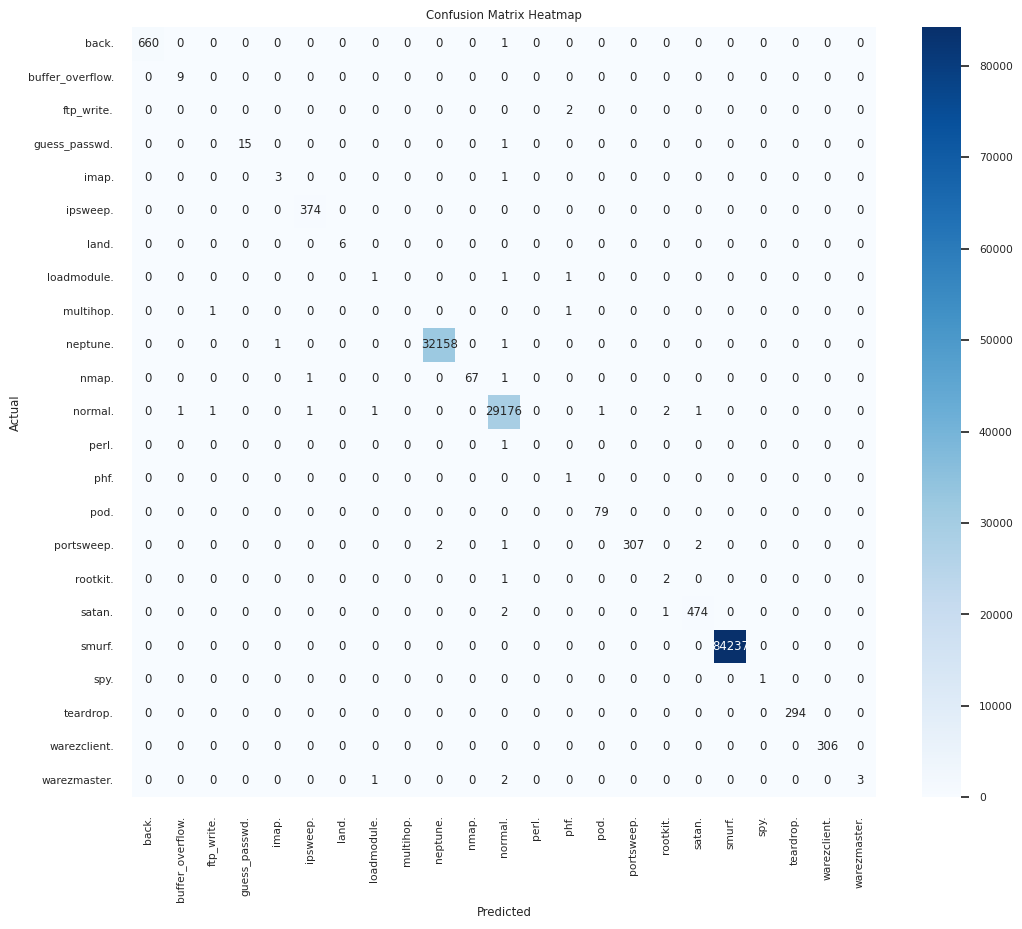

In [73]:
# Create heatmap
plt.figure(figsize=(12, 10))  # specify the size of the figure
sns.set(font_scale=0.7)  # increase the font size
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=lgbmc.classes_, yticklabels=lgbmc.classes_)  # add x and y tick labels

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

## saving the model to disk

In [75]:
# save model
joblib.dump(lgbmc, 'lgbmc_attack.pkl')


['lgbmc_attack.pkl']

## loading the model

In [2]:
# load model
lgbmc_attack = joblib.load('lgbmc_attack.pkl')

## predictions

In [32]:
%%time
df_to_score = df.iloc[:, :-1]
y_probas = lgbmc_attack.predict_proba(df_to_score)
df_y_probas = pd.DataFrame(y_probas, columns = lgbmc_attack.classes_)
y_pred = lgbmc_attack.predict(df_to_score)
s_y_pred = pd.Series(y_pred, name = 'predicted_class')
dff = pd.concat([df_y_probas, s_y_pred], axis = 1)
dff[list(lgbmc_attack.classes_)] = dff[list(lgbmc_attack.classes_)].astype('float32')

CPU times: user 7min 9s, sys: 9.61 s, total: 7min 19s
Wall time: 3min 23s


In [34]:
pd.set_option('display.float_format', '{:.8f}'.format)

In [38]:
dff.sample(20)

,back.,buffer_overflow.,ftp_write.,guess_passwd.,imap.,ipsweep.,land.,loadmodule.,multihop.,neptune.,nmap.,normal.,perl.,phf.,pod.,portsweep.,rootkit.,satan.,smurf.,spy.,teardrop.,warezclient.,warezmaster.,predicted_class
308325,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000001,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,smurf.
333266,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000001,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,smurf.
447572,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000001,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,smurf.
50573,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000001,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,smurf.
145802,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,normal.
404652,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000001,0.00000002,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.99999994,0.00000000,0.00000000,0.00000000,0.00000000,smurf.
492235,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,normal.
135469,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000001,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,smurf.
411985,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000001,0.00000002,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.99999994,0.00000000,0.00000000,0.00000000,0.00000000,smurf.
419043,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000001,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,smurf.
